In [9]:
# Imports CSV to open raw data
import csv

# Imports numpy to read label data
import numpy as np

# Sets autocompletion
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False

In [10]:
# Imports the best ML library ever: Tensorflow
import tensorflow as tf

# Imports the Keras API for Tensorflow
from tensorflow import keras

# Imports the layers, optimizers and metrics from Keras
from tensorflow.keras import layers, optimizers, metrics

# Imports the callbacks submodule from Keras API
from tensorflow.keras import callbacks

try:
    from gensim import models
except ModuleNotFoundError as e:
    !pip install gensim==3.8.0
    from gensim import models
try:
    import pandas as pd
except ModuleNotFoundError as e:
    !pip install pandas
    import pandas as pd    
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError as e:
    !pip install matplitlib
    import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support as score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix

try:
    import seaborn as sns
except ModuleNotFoundError as e:
    !pip install seaborn

In [11]:
def load_data(prefix):
    """ Loads the data from raw (preprocessed) datasets.
    
    Args:
        prefix (str): string with path prefix to datasets.
    
    Returns:
        dict: dictionary with the splitted dataset.
    
    """
    
    # Initalizes the output dictionary
    output_dict = {
        "train":None,
        "test":None,
        "validation":None
    }
    
    # Intializes the suffix dictionary
    suffix_dict = {
        "train": ["X_train.csv", "y_train.csv"],
        "test": ["X_test.csv", "y_test.csv"],
        "validation": ["X_val.csv", "y_val.csv"],
    }
    
    # Iterates over 
    for dataset in output_dict.keys():
        
        # Retrieves suffixes from dictionaty
        x_suffix, y_suffix = suffix_dict[dataset]
        
        # Initializes list for data
        x_data = []
        
        # Loads X data into a list
        with open(prefix + x_suffix, 'r', encoding='latin-1') as data:
            for row in csv.reader(data):
                
                # Creates a base string
                sentence_string = ""
                
                # Iterates over subwords and appends to string
                for subword in row:
                    sentence_string += " "
                    sentence_string += subword
                
                # Appends the sentence string
                x_data.append([sentence_string])
        
        # Converts input data to numpy array
        x_data = np.asarray(x_data)
        
        # Loads labels
        y_data = np.loadtxt(prefix + y_suffix)
               
        # Stores data into dictionary
        output_dict[dataset] = [x_data, y_data]

    # Returns output file
    return output_dict

In [28]:
simpsons_data = load_data("./data/simpsons/")

simpsons_dict = {
    0: "Bart",
    1: "Homer",
    2: "Lisa",
    3: "Marge"
}

In [42]:
def results_to_file(results, path, label_dict):
    
    # Creates the file
    with open(path, "w") as file:
    
        # Creates the writer
        csv_writer = csv.writer(file, delimiter=",")
    
        # Writes the title row
        csv_writer.writerow(["class", "precision", "recall", "F1"])
    
        # Iterates over class
        for i in range(len(results[0])):
            
            # List to write values
            values = []
            
            # Appends class name
            values.append(label_dict[i])
            
            # Appends precision value
            values.append("{:5.4f}".format(results[0][i]))
            
            # Appends recall value
            values.append("{:5.4f}".format(results[1][i]))
            
            # Appends f1 value
            values.append("{:5.4f}".format(results[2][i]))
            
            # Writes results into file
            csv_writer.writerow(values)
    

In [49]:
def create_confusion_matrix_plot(true, pred, title, path):

    sns.heatmap(confusion_matrix(np.argmax(true, axis=1), 
                                         np.argmax(pred, axis=1), normalize='pred'), cmap='Blues', annot=True)

    plt.title(title, fontsize=20)
    plt.xlabel('Predicted', fontsize=15)
    plt.ylabel('True', fontsize=15)
    plt.savefig(path)

## Simpsons Dataset

In [ ]:
# This line prevents TF crashing when using convolutional networks
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [15]:
# Creates the vectorization layer
encoder = layers.experimental.preprocessing.TextVectorization(
    max_tokens=10000,
    output_mode="int",
    output_sequence_length=15
)

# Adapts the training dataset
encoder.adapt(np.asarray(simpsons_data["train"][0], dtype=np.str))

# Creates the model
model = keras.Sequential([
    layers.Input(shape=(1, ), dtype=tf.string),
    encoder,
    layers.Embedding(input_dim=10000, output_dim=150),
    layers.Bidirectional(layers.LSTM(300)),
    layers.Dense(152),
    layers.Dense(4, activation="softmax")
])

# Creates the LR decrease callback
lr_decrease = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=1,
    cooldown=3,
    factor=0.1,
    verbose=1
)

# Creates a callback for early stopping
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=0
)

# Compiles the model
model.compile(
    optimizer=optimizers.Adam(lr=1e-4),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        metrics.Precision(name="precision"),
        metrics.Recall(name="recall")
    ]
)

# Trains the model
history = model.fit(
    x=simpsons_data["train"][0],
    y=simpsons_data["train"][1],
    epochs=50,
    validation_data=(simpsons_data["validation"][0], simpsons_data["validation"][1]),
    callbacks=[lr_decrease, early_stopping]
)

Epoch 1/50
1417/1417 [==============================] - 23s 13ms/step - loss: 1.2737 - accuracy: 0.4481 - precision: 0.5561 - recall: 0.0835 - val_loss: 1.1411 - val_accuracy: 0.5125 - val_precision: 0.7215 - val_recall: 0.2026
Epoch 2/50
1417/1417 [==============================] - 19s 13ms/step - loss: 1.0921 - accuracy: 0.5280 - precision: 0.6752 - recall: 0.2950 - val_loss: 1.1239 - val_accuracy: 0.5248 - val_precision: 0.6038 - val_recall: 0.3768
Epoch 3/50
1417/1417 [==============================] - 19s 13ms/step - loss: 1.0176 - accuracy: 0.5679 - precision: 0.6979 - recall: 0.3677 - val_loss: 1.1182 - val_accuracy: 0.5223 - val_precision: 0.6318 - val_recall: 0.3266
Epoch 4/50
1417/1417 [==============================] - 19s 13ms/step - loss: 0.9614 - accuracy: 0.5986 - precision: 0.7240 - recall: 0.4212 - val_loss: 1.1410 - val_accuracy: 0.5174 - val_precision: 0.6162 - val_recall: 0.3499

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


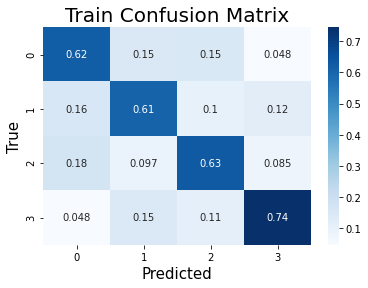

In [53]:
y_true_train = simpsons_data["train"][1]
y_pred_train = model.predict(simpsons_data["train"][0])
train = score(np.argmax(y_true_train, axis=1), np.argmax(y_pred_train, axis=1))

results_to_file(train, "./doc/data/results/simpsons_train.csv", simpsons_dict)
create_confusion_matrix_plot(
    y_true_train,
    y_pred_train,
    "Train Confusion Matrix",
    "./doc/images/simpsons_train_confusion.pdf"
)

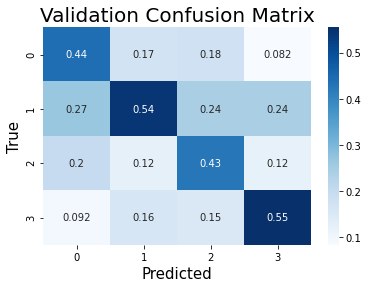

In [54]:
y_true_val = simpsons_data["validation"][1]
y_pred_val = model.predict(simpsons_data["validation"][0])
val = score(np.argmax(y_true_val, axis=1), np.argmax(y_pred_val, axis=1))

results_to_file(val, "./doc/data/results/simpsons_val.csv", simpsons_dict)
create_confusion_matrix_plot(
    y_true_val,
    y_pred_val,
    "Validation Confusion Matrix",
    "./doc/images/simpsons_val_confusion.pdf"
)

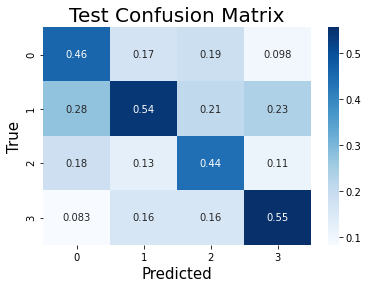

In [55]:
y_true_test = simpsons_data["test"][1]
y_pred_test = model.predict(simpsons_data["test"][0])
test = score(np.argmax(y_true_test, axis=1), np.argmax(y_pred_test, axis=1))

results_to_file(test, "./doc/data/results/simpsons_test.csv", simpsons_dict)
create_confusion_matrix_plot(
    y_true_test,
    y_pred_test,
    "Test Confusion Matrix",
    "./doc/images/simpsons_test_confusion.pdf"
)

## Friends Dataset

In [95]:
train_ds = tf.data.experimental.make_csv_dataset(
    "./data/friends/train_ds.csv",
    batch_size=32,
    column_names = ["sentence", "character"],
    label_name="character",
    num_epochs=1
)

val_ds = tf.data.experimental.make_csv_dataset(
    "./data/friends/val_ds.csv",
    batch_size=32,
    column_names = ["sentence", "character"],
    label_name="character",
    num_epochs=1
)

test_ds = tf.data.experimental.make_csv_dataset(
    "./data/friends/test_ds.csv",
    batch_size=32,
    column_names = ["sentence", "character"],
    label_name="character",
    num_epochs=1
)

friends_dataset = load_data("./data/friends/")

# Sets the vocabulary size and sequence length
VOCAB = 15000
MAX_TOKENS=20

# Sets the vectorization
VECT = "tf-idf"

# Creates the LR decrease callback
lr_decrease = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=1,
    cooldown=3,
    factor=0.1,
    verbose=1
)

# Creates a callback for early stopping
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=0
)

In [96]:
# Maps to create train text dataset
train_text = train_ds.map(lambda x, y: x["sentence"])

# Creates the vectorization layer
bin_vectorize_layer = layers.experimental.preprocessing.TextVectorization(
    output_mode=VECT,
    max_tokens=VOCAB,
    pad_to_max_tokens=MAX_TOKENS
)

# Trains the vectorization layer
bin_vectorize_layer.adapt(train_text)

# Function to map to vectorization layer
def vectorize_text(text, label):
    text = tf.expand_dims(text["sentence"], -1)
    return bin_vectorize_layer(text), label

train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)
test_ds = test_ds.map(vectorize_text)

train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, 6)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, 6)))
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, 6)))

model = keras.Sequential([
    layers.Input((VOCAB, )),
    layers.Dense(75),
    layers.Dense(150),
    layers.Dense(6, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall")]
)

history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[lr_decrease, early_stopping]
)

Epoch 1/20
1017/1017 [==============================] - 11s 10ms/step - loss: 1.7997 - accuracy: 0.1789 - precision: 0.2075 - recall: 1.2303e-04 - val_loss: 1.7871 - val_accuracy: 0.1986 - val_precision: 0.2857 - val_recall: 2.8682e-04
Epoch 2/20
1017/1017 [==============================] - 11s 11ms/step - loss: 1.7670 - accuracy: 0.2278 - precision: 0.5062 - recall: 3.9578e-04 - val_loss: 1.7698 - val_accuracy: 0.2214 - val_precision: 0.4167 - val_recall: 7.1705e-04
Epoch 3/20
1017/1017 [==============================] - 11s 11ms/step - loss: 1.7363 - accuracy: 0.2695 - precision: 0.6002 - recall: 8.0716e-04 - val_loss: 1.7540 - val_accuracy: 0.2371 - val_precision: 0.5500 - val_recall: 0.0016
Epoch 4/20
1017/1017 [==============================] - 11s 10ms/step - loss: 1.7044 - accuracy: 0.2990 - precision: 0.7053 - recall: 0.0018 - val_loss: 1.7391 - val_accuracy: 0.2521 - val_precision: 0.6216 - val_recall: 0.0033
Epoch 5/20
1017/1017 [==============================] - 11s 10ms/ste

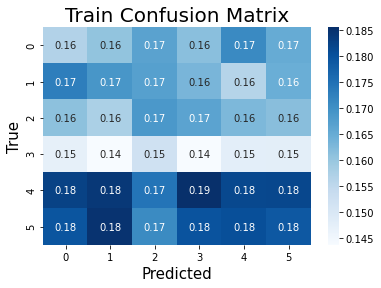

In [97]:
friends_dict = {
    0: "Chandler",
    1: "Joey",
    2: "Monica",
    3: "Phoebe",
    4: "Rachel",
    5: "Ross"
}

y_true_train = friends_dataset["train"][1]
y_pred_train = model.predict(train_ds.map(lambda x, y: x))
train = score(np.argmax(y_true_train, axis=1), np.argmax(y_pred_train, axis=1))

results_to_file(train, "./doc/data/results/friends_train.csv", friends_dict)
create_confusion_matrix_plot(
    y_true_train,
    y_pred_train,
    "Train Confusion Matrix",
    "./doc/images/friends_train_confusion.pdf"
)

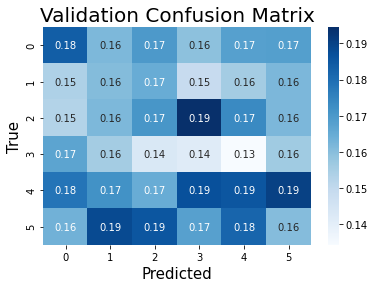

In [98]:
y_true_train = friends_dataset["validation"][1]
y_pred_train = model.predict(val_ds.map(lambda x, y: x))
train = score(np.argmax(y_true_train, axis=1), np.argmax(y_pred_train, axis=1))

results_to_file(train, "./doc/data/results/friends_val.csv", friends_dict)
create_confusion_matrix_plot(
    y_true_train,
    y_pred_train,
    "Validation Confusion Matrix",
    "./doc/images/friends_val_confusion.pdf"
)

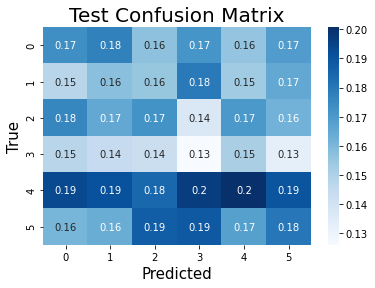

In [100]:
y_true_train = friends_dataset["test"][1]
y_pred_train = model.predict(test_ds.map(lambda x, y: x))
train = score(np.argmax(y_true_train, axis=1), np.argmax(y_pred_train, axis=1))

results_to_file(train, "./doc/data/results/friends_train.csv", friends_dict)
create_confusion_matrix_plot(
    y_true_train,
    y_pred_train,
    "Test Confusion Matrix",
    "./doc/images/friends_test_confusion.pdf"
)